<a href="https://colab.research.google.com/github/JihedSioud/ML-DL-examples/blob/main/DL_A_Medical_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we'll use the [mobile health (MHEALTH) dataset](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset). 

The goal is to predict the activity that people are doing based on the measurements from 23 channels (device outputs).



In [ ]:
! [ ! -f MHEALTHDATASET.zip ] && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip || echo "Data already downloaded!"
! [ -d MHEALTHDATASET ] && echo "Data already extracted" || unzip MHEALTHDATASET.zip
! ls
! ls MHEALTHDATASET


# Let us get some information on the dataset

with open("MHEALTHDATASET/README.txt", encoding = "ISO-8859-1") as f:
  for l in f.readlines(): print(l)

Data already downloaded!
Data already extracted
CNN-Model.png  MHEALTHDATASET  MHEALTHDATASET.zip  sample_data
mHealth_subject10.log  mHealth_subject4.log  mHealth_subject8.log
mHealth_subject1.log   mHealth_subject5.log  mHealth_subject9.log
mHealth_subject2.log   mHealth_subject6.log  README.txt
mHealth_subject3.log   mHealth_subject7.log


*************************************************** mHealth dataset **********************************************************



Authors: Oresti Baños, Rafael Garcia, Alejandro Saez

Date: 22/10/2013

Institution: University of Granada (UGR) 

Department: Department of Computer Architecture and Computer Technology.

Contact: oresti@ugr.es (oresti.bl@gmail.com)



---------------------------------------------------------------------------------------------------------------------------------------------

NOTE: if you use this dataset please cite the following work



Banos, O., Garcia, R., Holgado-Terriza, J.A., Damas, M., Pomares, H., Rojas, I., 

Let us know have a look at the data output, to understand what we're dealing with. This image helps explain what we do: we make shorter sequences of 100 points (2s @ 50Hz) that we'll use to train.

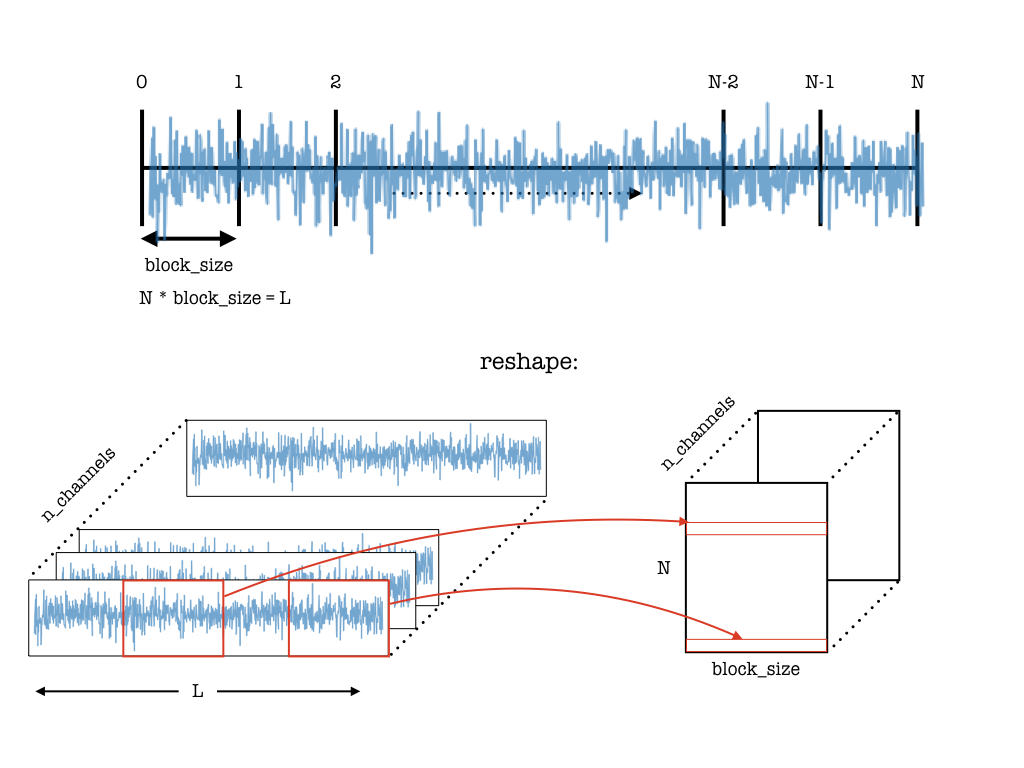


In [ ]:
import pandas as pd
import numpy as np

def read_subject(i):
  print(f"Processing file MHEALTHDATASET/mHealth_subject{i}.log")
  data = pd.read_csv(f"MHEALTHDATASET/mHealth_subject{i}.log", delimiter='\t',header=None)
  # Removing null class
  data = data[data[23]!=0]
  return data

# Let's make blocks of 100 points (i.e. 2s worth of points)
def split_in_blocks(data, block_size=100):
  X_ = []
  y_ = []

  groups = data.groupby(23)
  n_channels = data.shape[1]-1

  for gid in range(1,len(groups)+1):
    y = pd.unique(groups.get_group(gid)[23].to_numpy())
    x = groups.get_group(gid).drop(23, axis=1).to_numpy()
    n_blocks = len(x) // block_size

    x = x[:n_blocks*block_size]
    y = y[:n_blocks*block_size]

    x_tensor = x.reshape(-1, block_size, n_channels)

    # Append
    X_.append(x_tensor)
    y_.append(np.array([y]*len(x_tensor), dtype=int).squeeze())

  # Concatenate and return
  X = np.concatenate(X_, axis=0)
  y = np.concatenate(y_, axis=0)
  return X, y

block_size = 100
# Creating lists to save data
X_ = []
y_ = []
for s in range(1,11):
  data = read_subject(s)
  X, y = split_in_blocks(data, block_size)
  X_.append(X)
  y_.append(y)
# Concatenate
X = np.concatenate(X_, axis=0)
y = np.concatenate(y_, axis=0)

print(X.shape, y.shape)

# Code to bring everything in in one go
# data_list = []
# for i in range(1,11):
#   data = read_subject(i)
#   data_list.append( data )
# data = pd.concat(data_list, axis=0, ignore_index=True)
# print(data.head())
# # Checking the shape of our data
# print(data.shape)
# for i in range(1,13):
#   print(f"{i}: {data[data[23]==i].shape}")

Processing file MHEALTHDATASET/mHealth_subject1.log
Processing file MHEALTHDATASET/mHealth_subject2.log
Processing file MHEALTHDATASET/mHealth_subject3.log
Processing file MHEALTHDATASET/mHealth_subject4.log
Processing file MHEALTHDATASET/mHealth_subject5.log
Processing file MHEALTHDATASET/mHealth_subject6.log
Processing file MHEALTHDATASET/mHealth_subject7.log
Processing file MHEALTHDATASET/mHealth_subject8.log
Processing file MHEALTHDATASET/mHealth_subject9.log
Processing file MHEALTHDATASET/mHealth_subject10.log
(3355, 100, 23) (3355,)


Now that `X` represents the data from the 23 channels and the `y` the activity identifier (from 1 to 12), we can use the dataset.

We now need to split our data between the *training* and *testing* samples.
(We might even go further as we have a lot of data points.)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=123)

# Standardize
def standardise(X): return (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

X_train = standardise(X_train)
X_test = standardise(X_test)

# Train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.4, stratify=y_train, random_state=456)

# One-hot encoding
def one_hot(labels, n_class): return np.eye(n_class)[:,labels-1].T

y_train = one_hot(y_train, n_class=12)
y_valid = one_hot(y_valid, n_class=12)
y_test = one_hot(y_test, n_class=12)

# Getting some numbers out
print("Training set size: ", len(X_train))
print("Validaton set size: ", len(X_valid))
print("Test set size: ", len(X_test))

Training set size:  1408
Validaton set size:  940
Test set size:  1007


Let us now train a network

(100, 23, 1)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 98, 21, 32)        320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 49, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 47, 8, 64)         18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 23, 4, 64)        0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 5888)              0         
                                                                 
 dropout_19 (Dropout)        (None, 5888

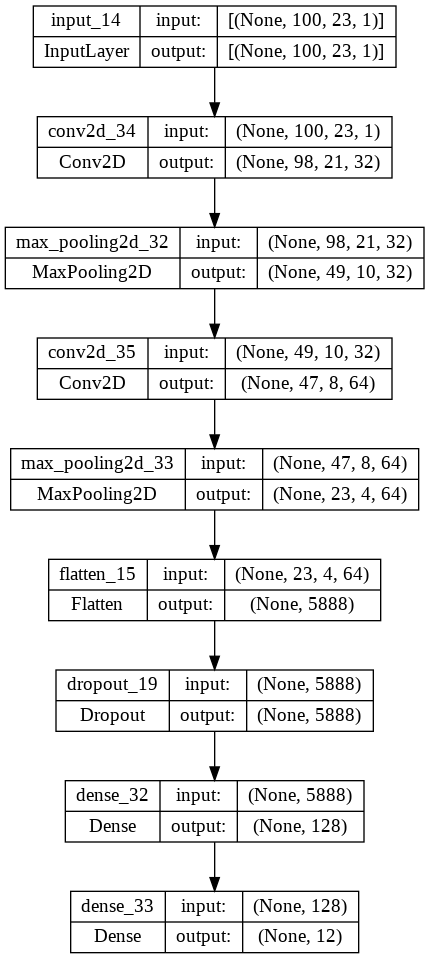

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

num_classes = 12
input_shape = (block_size, 23,1)
print(input_shape)
model = keras.Sequential(

    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]

)
# Shows a nice summary of the model
model.summary()

!pip install pydot
from tensorflow.keras.utils import plot_model

plot_model(model, 'CNN-Model.png', show_shapes=True)

Let's train our network.

In [ ]:
batch_size = 128
epochs = 20

# Feel free to change parameters below if needed
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
10/10 [==============================] - 4s 348ms/step - loss: 2.0767 - accuracy: 0.3528 - val_loss: 1.5970 - val_accuracy: 0.4681
Epoch 2/20
10/10 [==============================] - 3s 318ms/step - loss: 1.1199 - accuracy: 0.6298 - val_loss: 0.7952 - val_accuracy: 0.7518
Epoch 3/20
10/10 [==============================] - 5s 456ms/step - loss: 0.6157 - accuracy: 0.7972 - val_loss: 0.4246 - val_accuracy: 0.8936
Epoch 4/20
10/10 [==============================] - 5s 457ms/step - loss: 0.3654 - accuracy: 0.8848 - val_loss: 0.2770 - val_accuracy: 0.9362
Epoch 5/20
10/10 [==============================] - 4s 439ms/step - loss: 0.2539 - accuracy: 0.9313 - val_loss: 0.2038 - val_accuracy: 0.9504
Epoch 6/20
10/10 [==============================] - 4s 443ms/step - loss: 0.1814 - accuracy: 0.9519 - val_loss: 0.3067 - val_accuracy: 0.9362
Epoch 7/20
10/10 [==============================] - 5s 485ms/step - loss: 0.1450 - accuracy: 0.9629 - val_loss: 0.1264 - val_accuracy: 0.9716
Epoch 

Let us plot the performance of our algorithm.

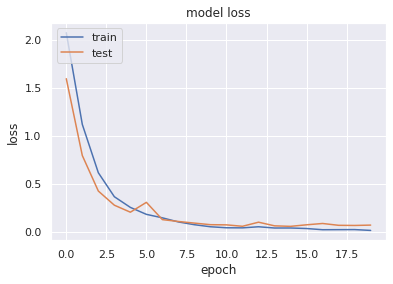

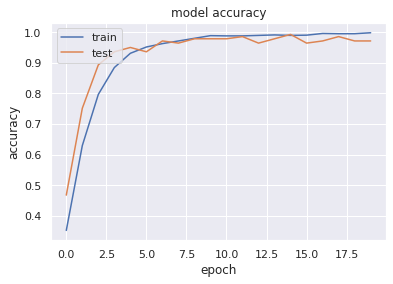

In [ ]:
def plot_history(history):
  import matplotlib.pyplot as plt
  %matplotlib inline

  for k in [ 'loss', 'accuracy']:
    # summarize history for accuracy
    plt.plot(history.history[f'{k}'])
    plt.plot(history.history[f'val_{k}'])
    plt.title(f'model {k}')
    plt.ylabel(f'{k}')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history)

1. Please provide some information on the performance of your model and a training.
**Answer:**

**Loss curve during training. It gives us a snapshot of the training process and the direction in which the network learns**

**It allows us to evaluate  if the learning rate is adequate or not**

**The accuracy curve allows us to evaluate overfitting to avoid it the test and the learning accracy curve shouldnot deviate much from one another**

**We can see from these 2 curves that our algorithm is well balanced**

Obtaining the confusion matrix for the model.


32/32 [==============================] - 1s 26ms/step
Correcly classified 977 out of 1007 sequences (97.02085402184707%)


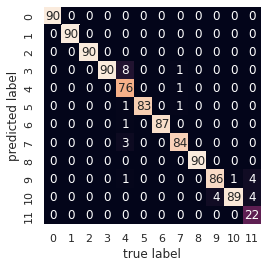

30/30 [==============================] - 1s 21ms/step
Correcly classified 922 out of 940 sequences (98.08510638297872%)


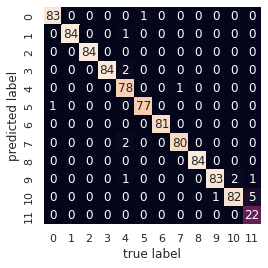

105/105 [==============================] - 3s 32ms/step
Correcly classified 3299 out of 3355 sequences (98.33084947839046%)


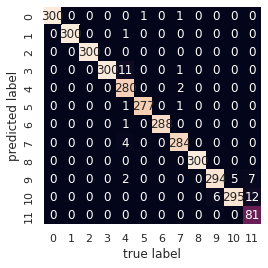

In [ ]:
def analyse_classifier(model, X, y):
  yPred = model.predict(X, verbose=1)
  from sklearn.metrics import confusion_matrix
  # Don't forget that in our model we have labels from 1 to 12
  cm = confusion_matrix(y.argmax(axis=1)+1, yPred.argmax(axis=1)+1)

  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns; sns.set()
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  nTotal = len(y)
  nCorrect = np.count_nonzero(y.argmax(axis=1)-yPred.argmax(axis=1)==0)
  print(f"Correcly classified {nCorrect} out of {nTotal} sequences ({nCorrect/nTotal*100}%)")

  plt.show()

analyse_classifier(model, X_test, y_test)
analyse_classifier(model, X_valid, y_valid)

# Running on the complete dataset
# We first need to standardise our input (which we didn't do before)
X_std = standardise(X)
# And we need to conver the full y into one-hot notation
analyse_classifier(model, X_std, one_hot(y, n_class=12))

## Training another classifier

1. Can you train another model ?

Feel free to split into multiple text/code blocks.

**We will start by using he same architecture as the first model with a different optimizer**

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


12/12 [==============================] - 4s 283ms/step - loss: 2.0136 - accuracy: 0.2735 - val_loss: 1.5329 - val_accuracy: 0.4433
Epoch 2/30
12/12 [==============================] - 2s 194ms/step - loss: 1.3732 - accuracy: 0.5577 - val_loss: 1.2270 - val_accuracy: 0.5390
Epoch 3/30
12/12 [==============================] - 2s 198ms/step - loss: 1.0521 - accuracy: 0.6661 - val_loss: 1.0596 - val_accuracy: 0.6702
Epoch 4/30
12/12 [==============================] - 2s 197ms/step - loss: 0.8928 - accuracy: 0.6963 - val_loss: 0.7660 - val_accuracy: 0.7340
Epoch 5/30
12/12 [==============================] - 2s 198ms/step - loss: 0.7517 - accuracy: 0.7567 - val_loss: 0.7205 - val_accuracy: 0.7624
Epoch 6/30
12/12 [==============================] - 2s 200ms/step - loss: 0.6497 - accuracy: 0.8037 - val_loss: 0.6489 - val_accuracy: 0.8191
Epoch 7/30
12/12 [==============================] - 2s 196ms/step - loss: 0.5982 - accuracy: 0.8091 - val_loss: 0.5538 - val_accuracy: 0.8475
Epoch 8/30
12/12 

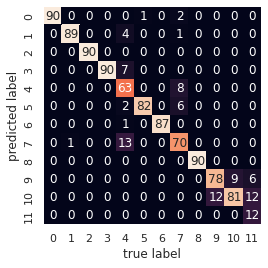

30/30 [==============================] - 1s 22ms/step
Correcly classified 878 out of 940 sequences (93.40425531914893%)


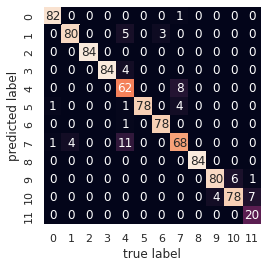

105/105 [==============================] - 2s 21ms/step
Correcly classified 3147 out of 3355 sequences (93.80029806259314%)


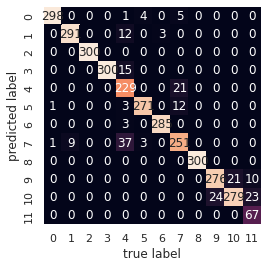

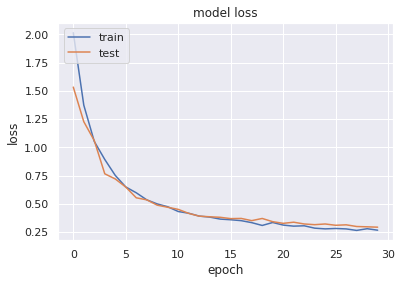

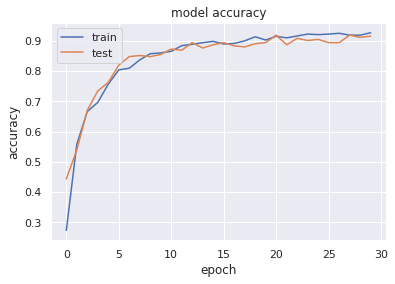

In [ ]:
# Put your code here to train and evaluate another model (next cell)

# Model definition
model1 = keras.Sequential(

    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]

)

from keras.optimizers import SGD
# Training
sgd = SGD(lr=0.2, decay=0.3,momentum= 0.4, nesterov=False)
batch_size = 100
epochs = 30
model1.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

#eval
analyse_classifier(model1, X_test, y_test)
analyse_classifier(model1, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model1, X_std, one_hot(y, n_class=12))
plot_history(history)

**We achieved slightly lower performance by changing the optimizer**



2. Can you try yet another ?

Try varying the parameters (copying to yet another cell ; don't forget to adjust the model variable to `model_3` or more).

In [ ]:
# Put your code here to train and evaluate another model (next cell)

# Model definition
model2 = keras.Sequential(

    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
        
    ]

)


batch_size = 128
epochs = 25

# Feel free to change parameters below if needed
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
10/10 [==============================] - 3s 289ms/step - loss: 2.3847 - accuracy: 0.1697 - val_loss: 2.1872 - val_accuracy: 0.3191
Epoch 2/25
10/10 [==============================] - 3s 268ms/step - loss: 1.9047 - accuracy: 0.3260 - val_loss: 1.8453 - val_accuracy: 0.4752
Epoch 3/25
10/10 [==============================] - 3s 277ms/step - loss: 1.6125 - accuracy: 0.4365 - val_loss: 1.5252 - val_accuracy: 0.5319
Epoch 4/25
10/10 [==============================] - 3s 320ms/step - loss: 1.3188 - accuracy: 0.5517 - val_loss: 1.1786 - val_accuracy: 0.7163
Epoch 5/25
10/10 [==============================] - 3s 271ms/step - loss: 1.0795 - accuracy: 0.6330 - val_loss: 0.9366 - val_accuracy: 0.7518
Epoch 6/25
10/10 [==============================] - 3s 267ms/step - loss: 0.8750 - accuracy: 0.7190 - val_loss: 0.6916 - val_accuracy: 0.8156
Epoch 7/25
10/10 [==============================] - 3s 280ms/step - loss: 0.7094 - accuracy: 0.7561 - val_loss: 0.5514 - val_accuracy: 0.8582
Epoch 

Evaluation

32/32 [==============================] - 1s 21ms/step
Correcly classified 977 out of 1007 sequences (97.02085402184707%)


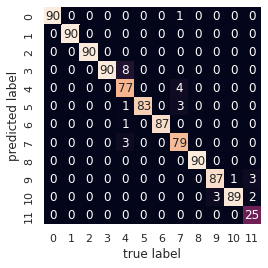

30/30 [==============================] - 1s 21ms/step
Correcly classified 921 out of 940 sequences (97.97872340425532%)


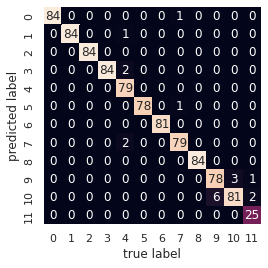

105/105 [==============================] - 2s 21ms/step
Correcly classified 3298 out of 3355 sequences (98.301043219076%)


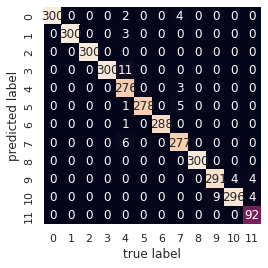

In [ ]:
analyse_classifier(model2, X_test, y_test)
analyse_classifier(model2, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model2, X_std, one_hot(y, n_class=12))

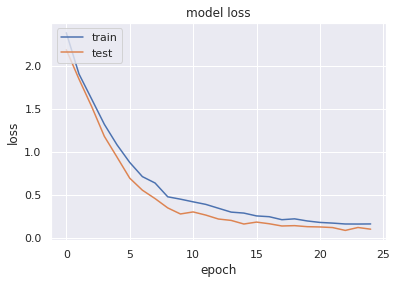

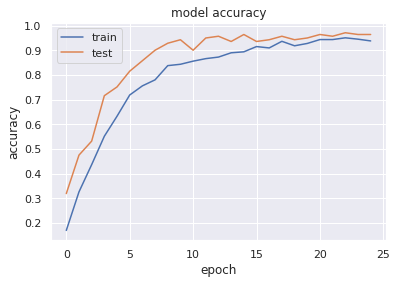

In [ ]:
plot_history(history)

### Yet another model

**Here we will try a much complicated model**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, BatchNormalization,Dense
from keras.models import Sequential

# Define the model
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(12, activation='softmax'))
# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
history= model3.fit(X_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
11/11 [==============================] - 3s 260ms/step - loss: 2.3226 - accuracy: 0.4659
Epoch 2/30
11/11 [==============================] - 3s 267ms/step - loss: 0.8492 - accuracy: 0.7571
Epoch 3/30
11/11 [==============================] - 3s 263ms/step - loss: 0.4253 - accuracy: 0.8658
Epoch 4/30
11/11 [==============================] - 3s 262ms/step - loss: 0.2834 - accuracy: 0.9141
Epoch 5/30
11/11 [==============================] - 3s 260ms/step - loss: 0.1844 - accuracy: 0.9354
Epoch 6/30
11/11 [==============================] - 3s 261ms/step - loss: 0.1666 - accuracy: 0.9375
Epoch 7/30
11/11 [==============================] - 3s 258ms/step - loss: 0.1323 - accuracy: 0.9510
Epoch 8/30
11/11 [==============================] - 3s 258ms/step - loss: 0.0913 - accuracy: 0.9666
Epoch 9/30
11/11 [==============================] - 3s 263ms/step - loss: 0.0832 - accuracy: 0.9659
Epoch 10/30
11/11 [==============================] - 3s 258ms/step - loss: 0.0650 - accuracy: 0.9787

Evaluation

32/32 [==============================] - 1s 22ms/step
Correcly classified 797 out of 1007 sequences (79.1459781529295%)


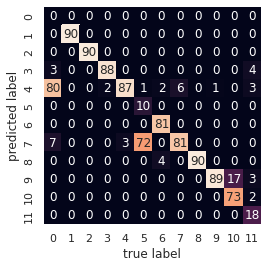

30/30 [==============================] - 1s 22ms/step
Correcly classified 760 out of 940 sequences (80.85106382978722%)


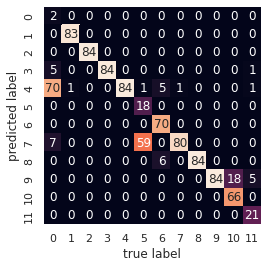

105/105 [==============================] - 2s 22ms/step
Correcly classified 2745 out of 3355 sequences (81.81818181818183%)


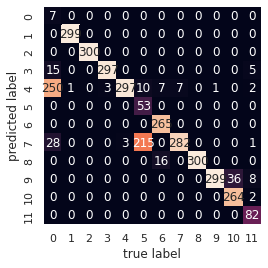

In [ ]:
analyse_classifier(model3, X_test, y_test)
analyse_classifier(model3, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model3, X_std, one_hot(y, n_class=12))

**We can see that using a more complicated network with more layer that performs better in training does not nececessarily mean that it will have better performance on an independent dataset in this case we have a worse generalisation than the simpler initial model**

# Wrapping up

*Note: use this space for thoughts; this part is not part of the mark (unless you don't fill it at all).*

What did you take out from this?

**Answer:Experimenting with different models and parameters can provide a better understanding of the problem and the relationship between the input and output variables. By trying different models and parameters, we can prevent overfitting, which occurs when a model is too closely fit to the training data and does not generalize well to new data.**